<a href="https://colab.research.google.com/github/VRehnberg/pairwise_modularity/blob/main/pairwise_similarity_modularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [1]:
# Basic utilities
import os
import gc
import urllib
import warnings
from math import pi
from functools import partial
from tqdm.auto import tqdm

# Numerics
import numpy as np
from sklearn import cluster, manifold

# Machine learning
import torch
from torch import nn, optim
from torch.autograd.functional import jacobian
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import types

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina' 
sns.set_style("ticks")
plt.rcParams['figure.dpi'] = 160

torch.set_anomaly_enabled(True)
#torch.Tensor.numpy = (lambda g: lambda self: g(self.detach().cpu()))(torch.Tensor.numpy)

## Load MNIST

In [2]:
batch_size = 1024
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

INPUT_SHAPE = 1 * 28 * 28
OUTPUT_SHAPE = 10


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw




Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Generator
Using a [pretrained](https://colab.research.google.com/drive/12lFAHpVIVOHK8dVbZOlVxnMhFlfKnMND) Generator for MNIST data.

The Generators input distribution is a 100-dimensional multivariate standard normal. The gradient of a multivariate normal with covariance matrix $\Sigma = \mathrm{I}$ and zero mean is
$$\begin{aligned}
  \nabla f(\vec{x}) &= -\vec{x}f(\vec{x})\,, \\
  f(\vec{x}) &= \left(\frac{1}{2\pi}\right)^{\mathrm{dim}(\vec{x})} \mathrm{e}^{-\frac{1}{2}\vec{x}^\mathsf{T}\vec{x}} 
\end{aligned}$$

In [3]:
class GeneratorInput():

    def sample(self, batch_size):
        '''Samples Generator input distribution.'''
        x_in = torch.randn(
            batch_size, 100,
            device=device,
            requires_grad=True,
        )
        return x_in

    def gradient(self, x_in, normalized=False):
        '''Computes the gradient of x_in.'''
        x_in_squared = torch.einsum("b...,b...->b", x_in, x_in).unsqueeze(1)
        grad = -x_in * torch.exp(-0.5 * x_in_squared)
        if normalized:
            grad *= (2 * pi) ** x_in.shape[1]
        return grad
    
    def prob(self, x_in):
        x_in_squared = torch.einsum("b...,b...->b", x_in, x_in).unsqueeze(1)
        return torch.exp(-0.5 * x_in_squared) #unnormalized


class GeneratorNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        
        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(100, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 28 * 28),
            nn.Tanh()
        )
        self.input = GeneratorInput()

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], 28, 28)
        return img

    def generate(self, batch_size):
        '''Generates samples from MNIST input manifold.'''
        x_in = self.input.sample(batch_size)
        x_out = self(x_in)
        return x_out

generator = GeneratorNetwork()
generator.to(device)
generator.eval()

if not os.path.isdir('./pretrained'):
    os.makedirs('./pretrained')
print('downloading ...')
urllib.request.urlretrieve("https://github.com/VRehnberg/AISC5-ID/raw/master/mnist_generator.pth", "./pretrained/mnist_generator.pth")
generator.load_state_dict(torch.load('./pretrained/mnist_generator.pth', map_location=device))
print('done')


downloading ...
done


## Architecture

In [4]:
class MLP(nn.Module):
    def __init__(self, layers, Activation=nn.ReLU):
        super().__init__()
        self.input_shape = layers[0]
        hidden = [
            layer
            for li, lo in zip(layers, layers[1:])
            for layer in [nn.Linear(li, lo), Activation()]
        ][:-1]
        self.hidden = nn.ModuleList(hidden)

    def forward(self, x):
        x = x.view(-1, self.input_shape)
        for layer in self.hidden:
            x = layer(x)
        return x


## Network utilities

In [5]:
def get_activations(network, x):
    activations = []
    hooks = []
    for name, m in network.named_modules():
        if isinstance(m, nn.Linear):
            save_activations = lambda mod, inp, out: activations.append(out)
            hooks.append(m.register_forward_hook(save_activations))
    
    network(x)
    for h in hooks:
        h.remove()
    
    return torch.hstack(activations)


def batched_jacobian(func, x, to_embedding=False, **kwargs):

    # Copmute batched Jacobian
    new_func = lambda x: func(x).sum(0)
    jac = jacobian(new_func, x, **kwargs)
    
    if to_embedding:
        # Create embedding of shape (func(x[0]).nelement(), x.nelement())
        jac = jac.flatten(-x.ndim).flatten(end_dim=-2)
    else:
        # Move batch dimension first
        dims = torch.arange(jac.ndim, device=device)
        batch_dim = dims[-x.ndim]
        jac.movedims(dims[:batch_dim + 1], [batch_dim, *dims[:batch_dim]])

    return jac


def clean_mem():
    gc.collect()
    if device.type == "cuda":
        torch.cuda.empty_cache()


## Pairwise similarities loss term

In [7]:
def jacobian_mutual_information(jac):
    assert jac.ndim == 3
    n_out = jac.shape[1]
    device = jac.device

    # Compute correlation matrix
    jac = jac / jac.abs().mean((1, 2), keepdim=True)  # for numerical stability
    cov = jac.bmm(jac.transpose(1, 2))
    inv_std = 1 / cov.diagonal(dim1=1, dim2=2).sqrt()
    corr =  inv_std.unsqueeze(1) * cov * inv_std.unsqueeze(2)

    # Compute pairwise MI
    jmi = - 0.5 * torch.log(1 - corr**2)

    # Compute joint entropy
    raise NotImplementedError()

    # Compute adjacency based on normalized distance metric

    adj_mat = adj_mat.mean(0)
    adj_mat[torch.eye(n_out, dtype=bool, device=device)] = 1.0

    return adj_mat


In [9]:
def jacobian_correlation(jac):
    assert jac.ndim == 2
    jac = jac / jac.abs().mean()  # for numerical stability
    cov = jac @ jac.T
    inv_std = 1 / cov.diag().sqrt()
    corr = cov * inv_std * inv_std.unsqueeze(1)
    if torch.isnan(corr).any():
        warnings.warn("NaN found when calculating correlation.", RuntimeWarning)
    return corr

def jacobian_correlation_adjacency(jac):
    return jacobian_correlation(jac) ** 2


def coactivation(activations):
    return jacobian_correlation(activations.T) ** 2  # this is the adjacency matrix


def quantized_mutual_information(activations, qmin_bins):
    device = activations.device

    # Quantize activations
    batch_size, n_activations = activations.shape
    assert batch_size >= qmin_bins
    quantized_activations = qmin_bins * activations.argsort(0).argsort(0) // batch_size
    assert quantized_activations.shape == activations.shape

    # Compute pmfs
    activations_onehot = nn.functional.one_hot(quantized_activations).float()
    p_xy = torch.einsum("bij, bkl -> ikjl", activations_onehot, activations_onehot) / batch_size

    # Compute pairwise mutual information
    p_x = torch.einsum("iikk -> ik", p_xy)
    qmin = p_xy.div(p_x.unsqueeze(0).unsqueeze(2)).div(p_x.unsqueeze(1).unsqueeze(3)).pow(p_xy).log2().sum((2, 3))
    return qmin


def compute_adjacency_matrix(
    network,
    x,
    mode="jacobian",
    use_generator=False,
    generator=None,
    abs_coactivations=False,
    qmin_bins=2,
    create_graph=False,
):
    if mode=="jacobian" and use_generator:
        batch_size = x.shape[0]
        x_in = generator.input.sample(batch_size)
        grad = generator.input.gradient(x_in)
        
        def func(x_in):
            x_out = generator(x_in)
            return get_activations(network, x_out)
        jac = batched_jacobian(
            func,
            x_in,
            to_embedding=True,
            create_graph=create_graph,
        )
        assert not torch.allclose(jac, torch.zeros(1, device=device))
        jac = jac * grad.view(1, -1)

        adj_mat = jacobian_correlation_adjacency(jac)
    
    elif mode=="jacobian" and not use_generator:
        # Compute jacobian
        func = partial(get_activations, network)
        jac = batched_jacobian(
            func,
            x,
            to_embedding=True,
            create_graph=create_graph,
        )

        # Adjacency matrix from jacobian
        adj_mat = jacobian_correlation_adjacency(jac)
        
    elif mode=="coactivation":
        activations = get_activations(network, x)
        if abs_coactivations:
            activations = activations.abs()
        adj_mat = coactivation(activations)
    
    elif mode=="qmin":
        if create_graph:
            raise NotImplementedError(f"Mode {mode} is currently not differentiable.")
        activations = get_activations(network, x)
        qmin = quantized_mutual_information(activations, qmin_bins)
        adj_mat = qmin
    
    elif mode=="mutual_information":
        activations = get_activations(network, x)
        raise NotImplementedError()
        # TODO mutual information based on Gaussian KDE or similar

    
    else:
        raise ValueError(f"Mode {mode} is not valid.")

    return adj_mat


def compute_laplacian(adj_mat):
    '''Computes normalized Laplacian from embedding.
    
    Parameters:
        embedding (Tensor): n_neurons × n_features
    
    Returns:
        lap (Tensor): n_neurons × n_neurons
    '''
    device = adj_mat.device
    # Compute normalized laplacian
    inv_sqrt_degree = 1 / adj_mat.sum(0, keepdims=True).sqrt()
    adjnorm = adj_mat * inv_sqrt_degree * inv_sqrt_degree.T
    lap = torch.eye(adjnorm.shape[0]).to(device) - adjnorm

    return lap


class PairwiseSimilarityLoss(nn.modules.loss._Loss):

    __constants__ = ["reduction"]

    def __init__(
        self,
        mode="jacobian",
        use_generator=True,
        generator=None,
        abs_coactivations=False,
        qmin_bins=2,
        size_average=None,
        reduce=None,
        reduction='mean',
    ):
        super().__init__(size_average, reduce, reduction)
        self.adjacency = partial(
            compute_adjacency_matrix, 
            mode=mode,
            use_generator=use_generator,
            generator=generator,
            create_graph=True,
        )

    def forward(self, network, x, n_clusters):
        # Compute adjacency matrix
        adj_mat = self.adjacency(network, x)
        assert torch.allclose(adj_mat, adj_mat.T), "Adjacency matrix not symmetric."
        assert adj_mat.requires_grad, "Adjacency matrix doesn't reguire grad."

        # Compute normalized laplacian
        lap = compute_laplacian(adj_mat)
        assert torch.allclose(lap, lap.T), "Laplacian not symmetric."
    
        # Compute eigenvalues
        eigval, eigvec = torch.symeig(lap, eigenvectors=True)
        assert torch.allclose(eigval, eigval.sort(descending=False)[0]), "Eigenvalues not in ascending order."
        if (torch.diff(eigval[:n_clusters + 2]) < 1e-5).any():
            warnings.warn("Non-distinct eigenvalues. Backwards call might be unstable.")
        
        # Regularisation term
        loss = eigval[n_clusters]
    
        return loss


## Training

In [11]:
def train(
    network,
    dataloader,
    act_reg = 1.0,
    n_clusters = 3,
    n_epochs = 10,
    Optimizer = partial(optim.Adam, lr=0.01),
    pairwise_loss_function = PairwiseSimilarityLoss(
        mode="jacobian",
        use_generator=False,
    ),
    loss_function = nn.CrossEntropyLoss(),
):

    optimizer = Optimizer(network.parameters())

    #Train
    n_batches = len(dataloader)
    pbar = tqdm(desc="Train", total=(n_epochs * n_batches))
    for epoch in range(n_epochs):
    
        batch_loss = 0.0
        batch_actloss = 0.0
        batch_acc = 0.0
        
        for i_batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
    
            network.train()
            optimizer.zero_grad()
    
            y_estimate = network(x)
    
            # Usual loss
            loss = loss_function(y_estimate, y)
            batch_loss += loss.detach().cpu()
            
            # Accuracy
            batch_acc += (torch.argmax(y_estimate, dim=1) == y).float().mean().detach().cpu()
    
            # Activation regularisation
            if act_reg:
                actloss = act_reg * pairwise_loss_function(network, x, n_clusters)
    
                batch_actloss += actloss.detach().cpu()
                actloss.backward()
    
            pbar.update(1)
    
            # Retain graph to be able to reuse generator input in backward 
            loss.backward()
            optimizer.step()
    
        # Print metrics for this epoch
        avg_acc = batch_acc / n_batches
        avg_loss = batch_loss / n_batches
        avg_actloss = batch_actloss / n_batches
        al_str = f', AL: {avg_actloss:.4f}' if act_reg else ''
        pbar.write(f'Epoch {epoch}. Acc {avg_acc:.4f}, CE: {avg_loss:.4f}{al_str}')
    
        clean_mem()


In [12]:
#%%time
layers = [INPUT_SHAPE, 40, 40, 30, OUTPUT_SHAPE]
mlp = MLP(layers).to(device)
train(
    mlp,
    train_dataloader,
    act_reg = 0.0,
    pairwise_loss_function = PairwiseSimilarityLoss(
        mode="jacobian",
        use_generator=False,
        generator=generator,
        abs_coactivations=False,
    ),
)


Epoch 0. Acc 0.6930, CE: 0.9043
Epoch 1. Acc 0.9001, CE: 0.3311
Epoch 2. Acc 0.9244, CE: 0.2528
Epoch 3. Acc 0.9341, CE: 0.2171
Epoch 4. Acc 0.9398, CE: 0.1976
Epoch 5. Acc 0.9452, CE: 0.1799
Epoch 6. Acc 0.9479, CE: 0.1710
Epoch 7. Acc 0.9528, CE: 0.1560
Epoch 8. Acc 0.9541, CE: 0.1509
Epoch 9. Acc 0.9573, CE: 0.1399


## Different clusterings

In [13]:
n_clusters = 3
clusters = {}

def get_linkage_matrix(model):
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_neurons = len(model.labels_)
    for i, merge in enumerate(model.children_):
        counts[i] = sum([
            1 if child_idx < n_neurons else counts[child_idx - n_neurons]
            for child_idx in merge
        ])

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    return linkage_matrix

# Layer labels for neurons
# NB this assumes that named modules appear in order of their execution
i_layer = []
layer_counter = 1
for name, mod in mlp.named_modules():
    if isinstance(mod, nn.Linear):
        n_neurons = mod.out_features
        i_layer.extend(n_neurons * [layer_counter])
        layer_counter += 1
i_layer = np.array(i_layer)
clusters["Layer"] = i_layer

# Adjacency based clustering
mlp.eval()
n_activations = 120
n_batches = len(test_dataset)
clustering = cluster.AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=0,
    affinity="precomputed",
    linkage="average",
)
clustering = cluster.SpectralClustering(
    n_clusters=n_clusters,
    affinity="precomputed",
    n_init=100,
    assign_labels="discretize",
)
adjacency_matrices = {}
for name, adj_kwargs in tqdm([
    #("Jacobian", dict(mode="jacobian", use_generator=False)),
    ("GeneratorJacobian", dict(mode="jacobian", use_generator=True, generator=generator)),
    #("Coactivations", dict(mode="coactivation")),
    #("|Coactivations|", dict(mode="coactivation", abs_coactivations=True)),
    ("QMI", dict(mode="qmin", qmin_bins=5)),
]):
    adj_mat = torch.zeros([120, 120], device=device)
    for x, y in test_dataloader:
        x = x.to(device)
        adj_mat += compute_adjacency_matrix(mlp, x, **adj_kwargs)
    
    # This is only an approximation of the true adjacency matrix
    adj_mat /= n_batches
    adj_mat = adj_mat.detach().cpu().numpy()

    adjacency_matrices[name] = adj_mat

    # Cluster into modules
    model = clustering.fit(adj_mat)
    #linkage_matrix = get_linkage_matrix(model)
    #print(linkage_matrix)
    i_clusters = model.labels_
    #print(i_clusters)

    clusters[name] = i_clusters

# Randomly assign neurons to clusters
clusters["Random"] = np.random.randint(0, n_clusters, n_activations)

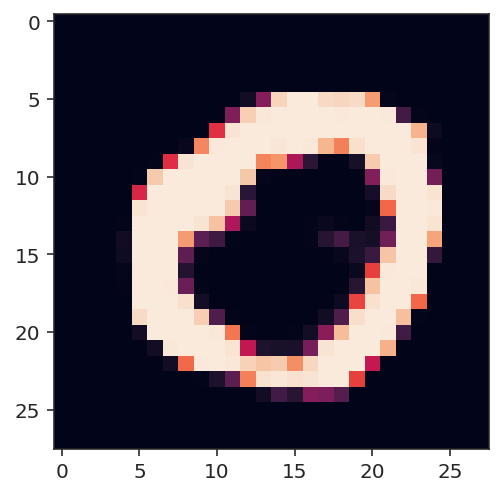

In [15]:
generator.eval()
latent = generator.input.sample(1)
image = generator(latent)
plt.imshow(image.detach().cpu().squeeze(0));

In [16]:
mlp(generator(latent))

tensor([[ 13.9357,  -8.4834,   3.5612, -13.0243,  -6.2109,  -1.2239,   0.9671,
          -0.4194,  -2.9147,   0.0574]], device='cuda:0',
       grad_fn=<AddmmBackward>)

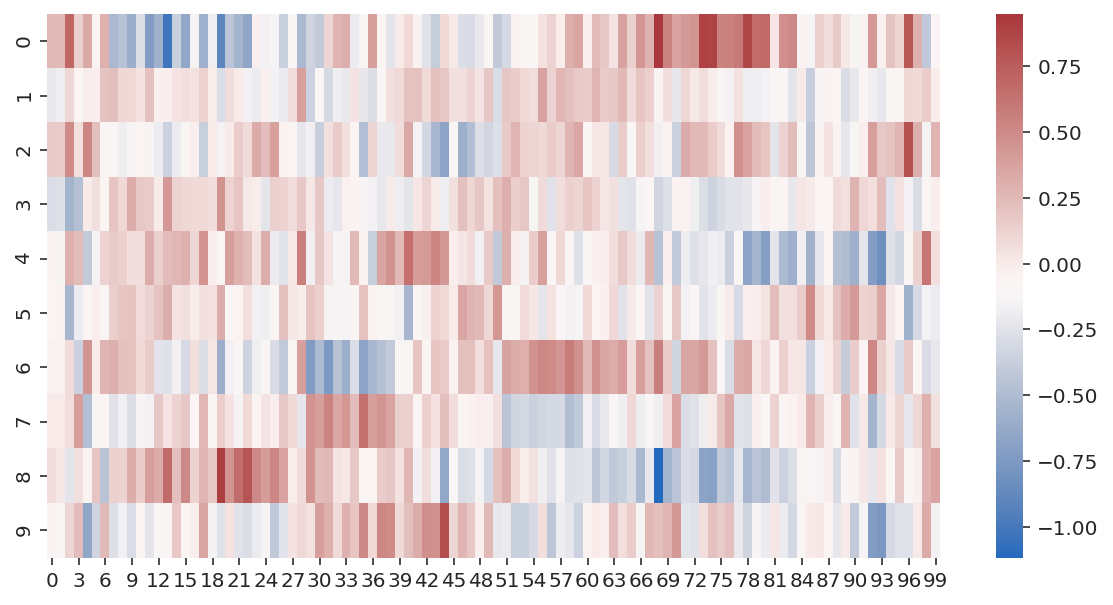

In [17]:
def tensor_sort(input, dim=0, **tsne_kwargs):
    samples = input.transpose(0, dim).flatten(1).detach().cpu().numpy()
    i_sort = np.argsort(manifold.TSNE(n_components=1, **tsne_kwargs).fit_transform(samples).squeeze())
    input = input.transpose(0, dim)[i_sort].transpose(0, dim)
    return input, i_sort

jac = jacobian(lambda x: mlp(generator(x)), latent).squeeze()
plt.figure(figsize=(10, 5))
jac, _ = tensor_sort(jac**3, 1, metric="cosine")
jac = jac.abs() ** (1 / 3) * jac.sign()
sns.heatmap(jac.detach().cpu(), cmap="vlag");

In [18]:
torch.svd(jac)[1]

tensor([5.9579e+00, 4.2073e+00, 3.8022e+00, 3.2609e+00, 1.0760e+00, 6.6171e-01,
        1.1956e-01, 4.8341e-02, 2.2563e-02, 3.1091e-07], device='cuda:0')

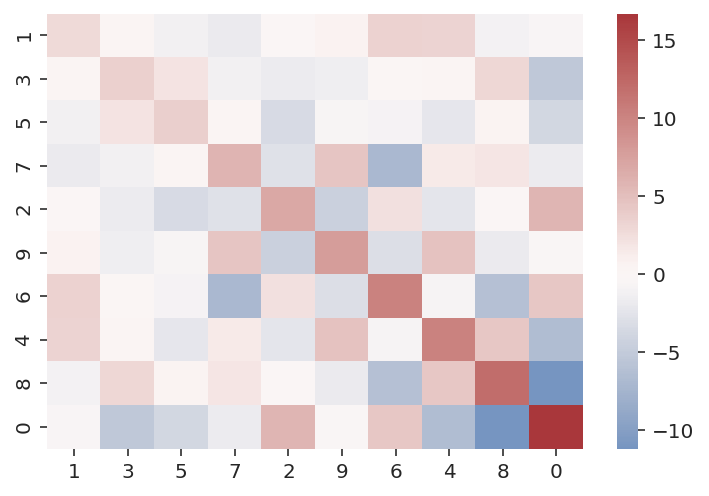

In [19]:
cov = jac @ jac.T
i_sort = np.argsort(cov.diag().detach().cpu().numpy())
cov = cov[i_sort, :][:, i_sort]
sns.heatmap(cov.detach().cpu(), cmap="vlag", center=0, xticklabels=i_sort, yticklabels=i_sort);

In [21]:
def condition(cov, observation):
    '''observation : projection @ jac'''
    # As an invariant, cov=cov²=cov.T
    # Formula 7 in http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf
    def sym(x):
      print("sym", (x-x.T).norm(), x.shape)
      torch.testing.assert_allclose(x, x.T)
    print(cov)
    sym(cov)
    sym(observation @ observation.T)
    sym(torch.pinverse(observation @ observation.T))
    #print(torch.pinverse(observation @ observation.T))
    #print(torch.pinverse(observation @ observation.T) - torch.pinverse(observation @ observation.T).T)
    sym(observation.T @ torch.pinverse(observation @ observation.T) @ observation)
    sym(observation.T @ torch.pinverse(observation @ observation.T) @ observation)
    sym(cov - observation.T @ torch.pinverse(observation @ observation.T) @ observation)
    sym(cov - cov @ observation.T @ torch.pinverse(observation @ cov @ observation.T) @ observation @ cov)
    return cov - observation.T @ torch.pinverse(observation @ observation.T) @ observation

# (A B) @ (C Y)   = A@C+B@D         AA* + BB* = (A B) @ (A B)*.     (A iB) @ (A iB)* = AA* - BB*
# (G H)   (D Z)

# A @ A^t

def condition_new(cov, cond):
    '''cond : projection @ jac'''
    # Formula 7 in http://www.cs.columbia.edu/~liulp/pdf/linear_normal_dist.pdf
    cond2 = cond @ cov
    cov2 = cov - cond2.pinverse() @ cond2
    print("orthoproj", (cov2-cov2.T).norm(), (cov2-cov2@cov2).norm(), cov2.shape)
    torch.testing.assert_allclose(cov2, cov2.T)
    torch.testing.assert_allclose(cov2, cov2 @ cov2)
    return cov2

torch.Tensor.condition = condition
torch.Tensor.condition_half = condition_half

jac = jacobian(lambda x: mlp(generator(x)), latent).squeeze()
plt.figure(figsize=(10, 5))
jac, _ = tensor_sort(jac, 1, metric="cosine")
projection = torch.zeros(10, device=device); projection[[5, 9]] = 1
cov = torch.eye(jac.shape[1], device=device)
cov = cov.condition_new(projection.diag() @ jac)
sns.heatmap(jac.detach().cpu(), cmap="vlag", center=0);
jac2 = jac @ cov
plt.figure(figsize=(10, 5))
sns.heatmap(jac2.detach().cpu(), cmap="vlag", center=0);

NameError: ignored

In [22]:
torch.tensor([[1.,0],[0,1]]).condition(torch.tensor([[1.,1.],[0,0]]))

tensor([[1., 0.],
        [0., 1.]])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])
sym tensor(0.) torch.Size([2, 2])


tensor([[ 0.5000, -0.5000],
        [-0.5000,  0.5000]])

RuntimeError: ignored

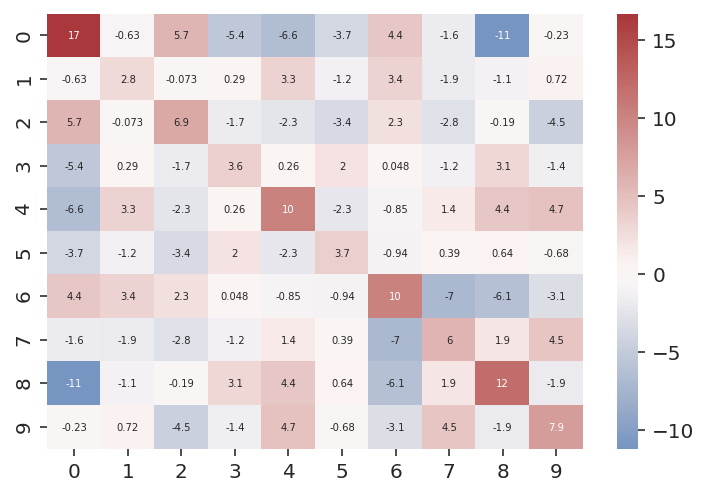

<Figure size 432x288 with 0 Axes>

In [23]:
sns.heatmap((jac @ jac.T).detach().cpu(), cmap="vlag", center=0, annot=True, annot_kws=dict(fontsize=5))
plt.figure()
sns.heatmap((jac @ cov @ jac.T).detach().cpu(), cmap="vlag", center=0, annot=True, annot_kws=dict(fontsize=5))

tensor(14, device='cuda:0') tensor(9, device='cuda:0')
tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')
sym tensor(0., device='cuda:0') torch.Size([100, 100])
sym tensor(0., device='cuda:0') torch.Size([10, 10])
sym tensor(136.3005, device='cuda:0') torch.Size([10, 10])
sym tensor(13.2698, device='cuda:0') torch.Size([100, 100])


AssertionError: ignored

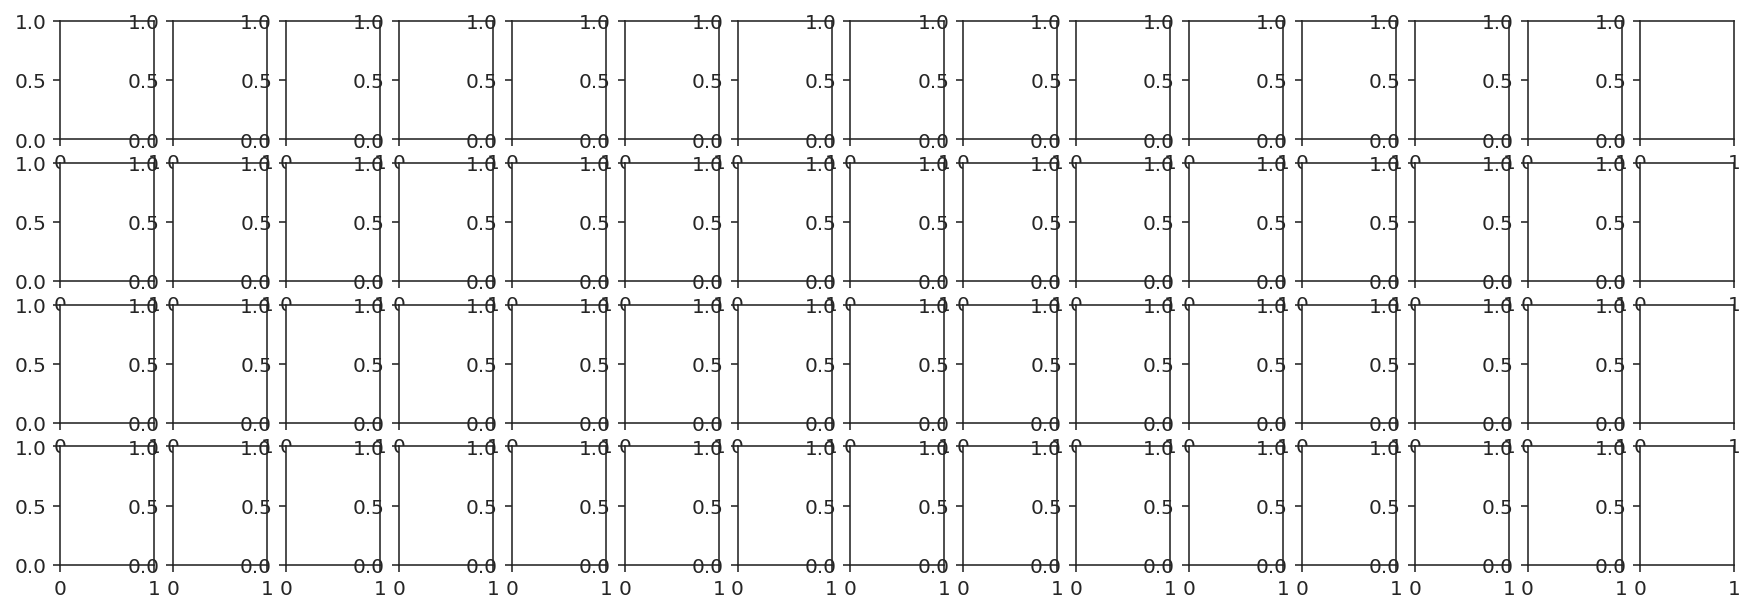

In [24]:
eps = 2.5
n_samples = 15
fig, axs = plt.subplots(4, n_samples, figsize=(15, 5))
mask = torch.eye(10, 1, device=device, dtype=bool).flatten()
for row, mask in enumerate([mask, ~mask]):
    jacl = jacobian(lambda x: mlp(x), generator(latent)).squeeze().flatten(1,2)
    jacr = jacobian(lambda x: generator(x), latent).squeeze().flatten(0,1)
    jac = jacobian(lambda x: mlp(generator(x)), latent).squeeze()
    torch.testing.assert_allclose(jacl @ jacr, jac)
    u, s, vt = torch.linalg.svd(jac, full_matrices=False)
    vt = vt[mask]
    cond = u @ s.diag()[:, mask] @ vt
    cov = torch.eye(jac.shape[1], device=device)
    print(torch.matrix_rank(jacr @ cov @ jacr.T), torch.matrix_rank(jac @ cov @ jac.T))
    cov = cov.condition(cond)
    print(torch.matrix_rank(jacr @ cov @ jacr.T), torch.matrix_rank(jac @ cov @ jac.T))
    #wut=torch.cholesky(cov)
    cu, cs, cvt = torch.linalg.svd(cov)
    #torch.testing.assert_allclose(cu.T, cvt)
    print((cov-cov.T).norm())
    noise = cs.sqrt() * torch.randn_like(cs)
    noise = cu @ noise

    for col in range(n_samples):
        new = latent + eps * (col - n_samples // 2) * noise
        image = generator(latent + eps * (col - n_samples // 2) * noise)
        axs[row*2, col].imshow(image.detach().cpu().squeeze())
        new *= latent.norm() / new.norm()
        axs[row*2+1, col].imshow(image.detach().cpu().squeeze())

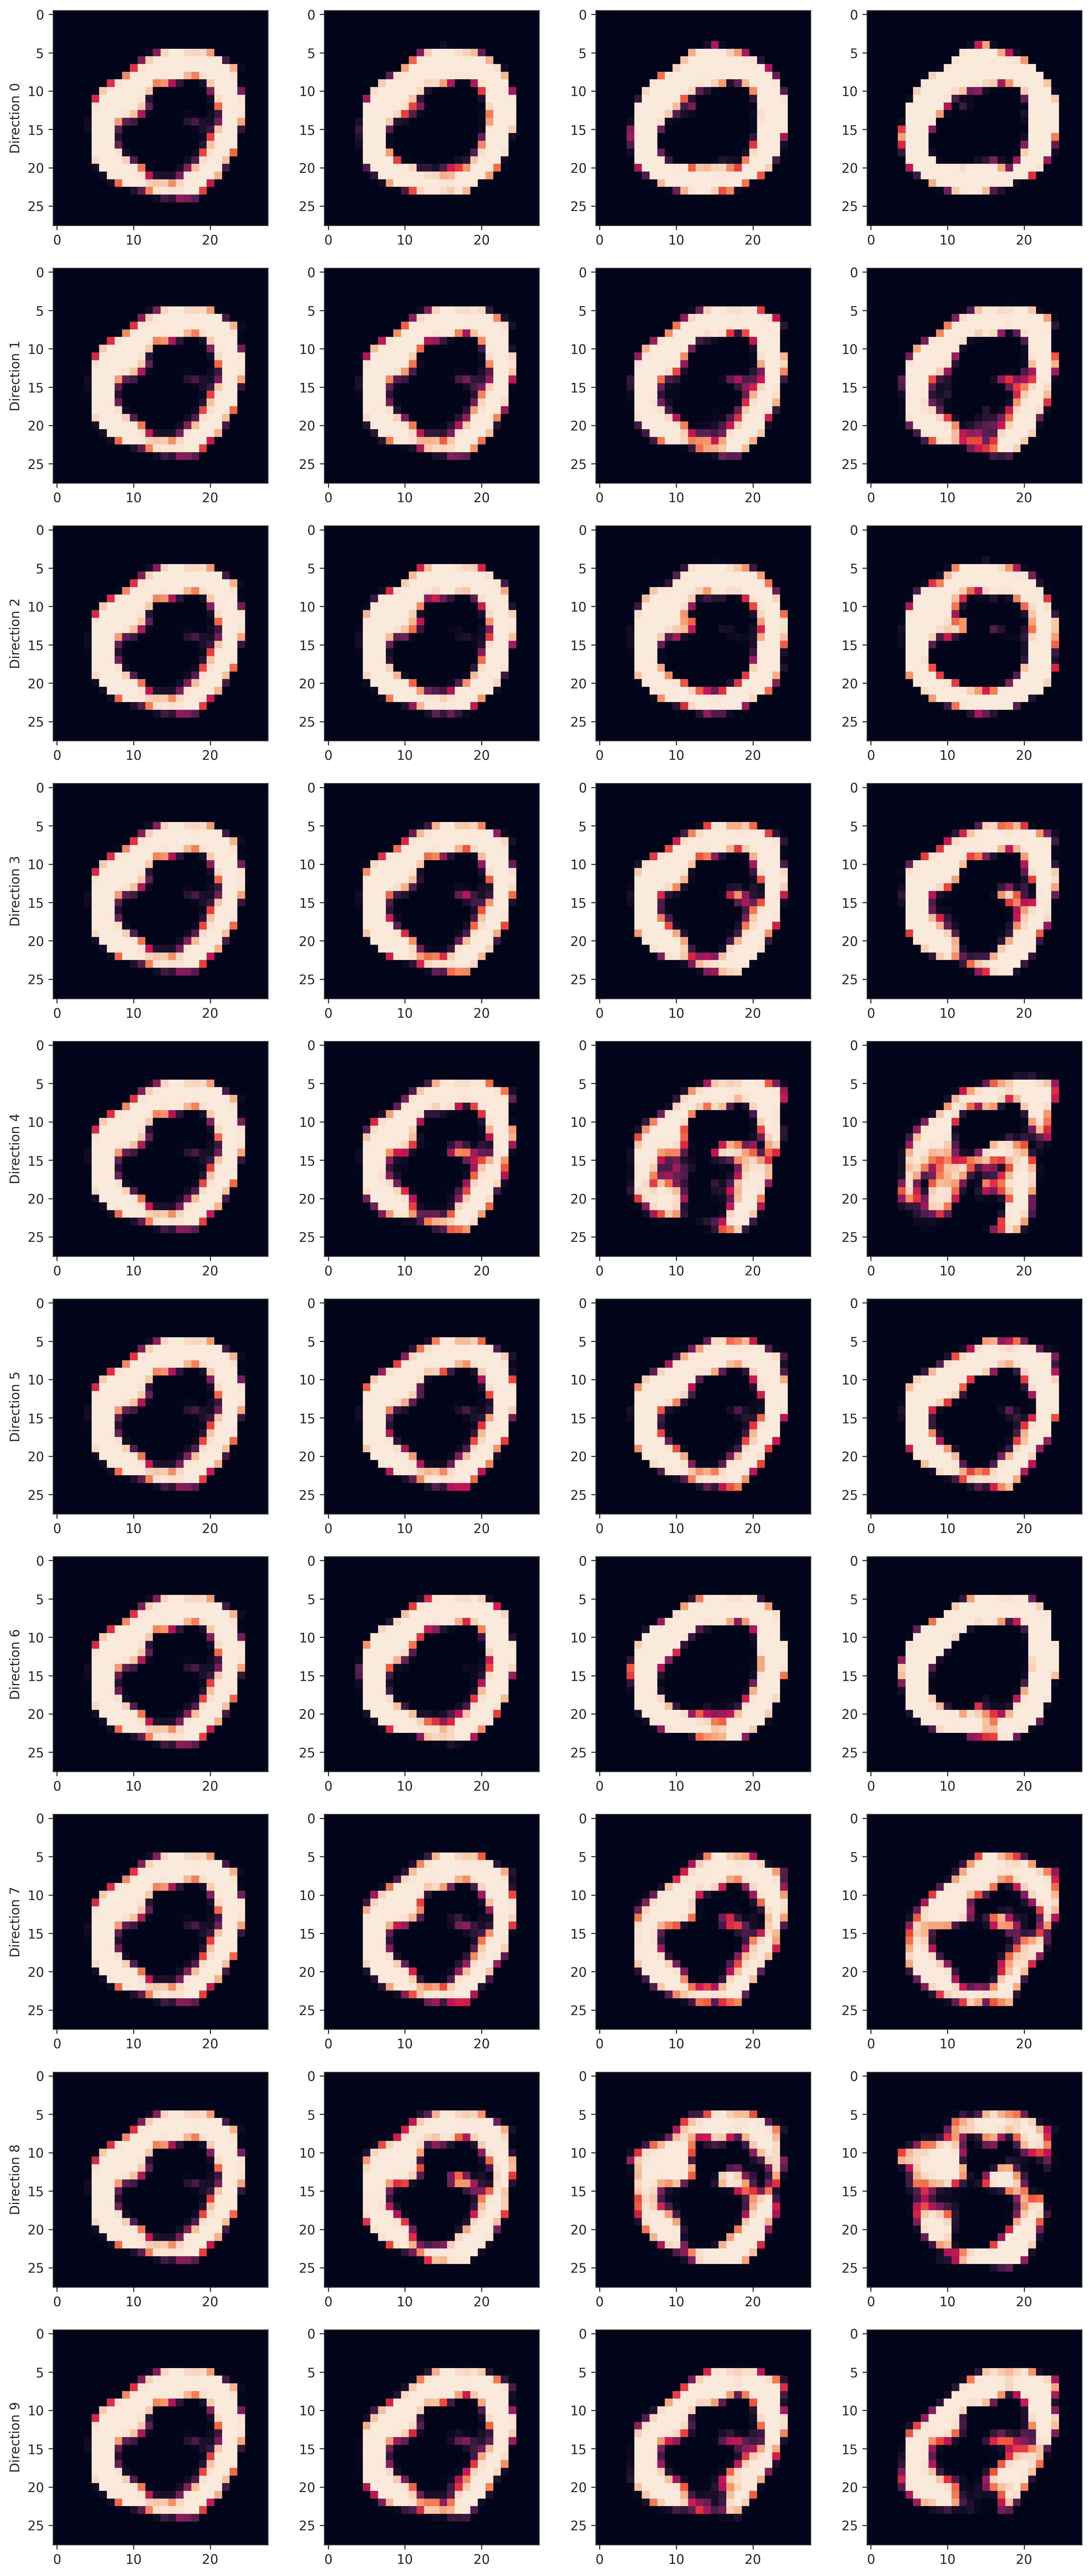

In [25]:
eps = 0.5

n = 4
fig, ax_grid = plt.subplots(10, n, dpi=150, figsize=(3.6*n, 3.6*10))
for digit, axs in enumerate(ax_grid):
    direction = jac[digit]
    axs[0].set_ylabel(f"Direction {digit}")
    for lamba, ax in zip(np.linspace(0, eps, n), axs):
        latent2 = latent + lamba * direction
        image = generator(latent2)
        ax.imshow(image.detach().cpu().squeeze(0));


## Visualise adjacency matrices

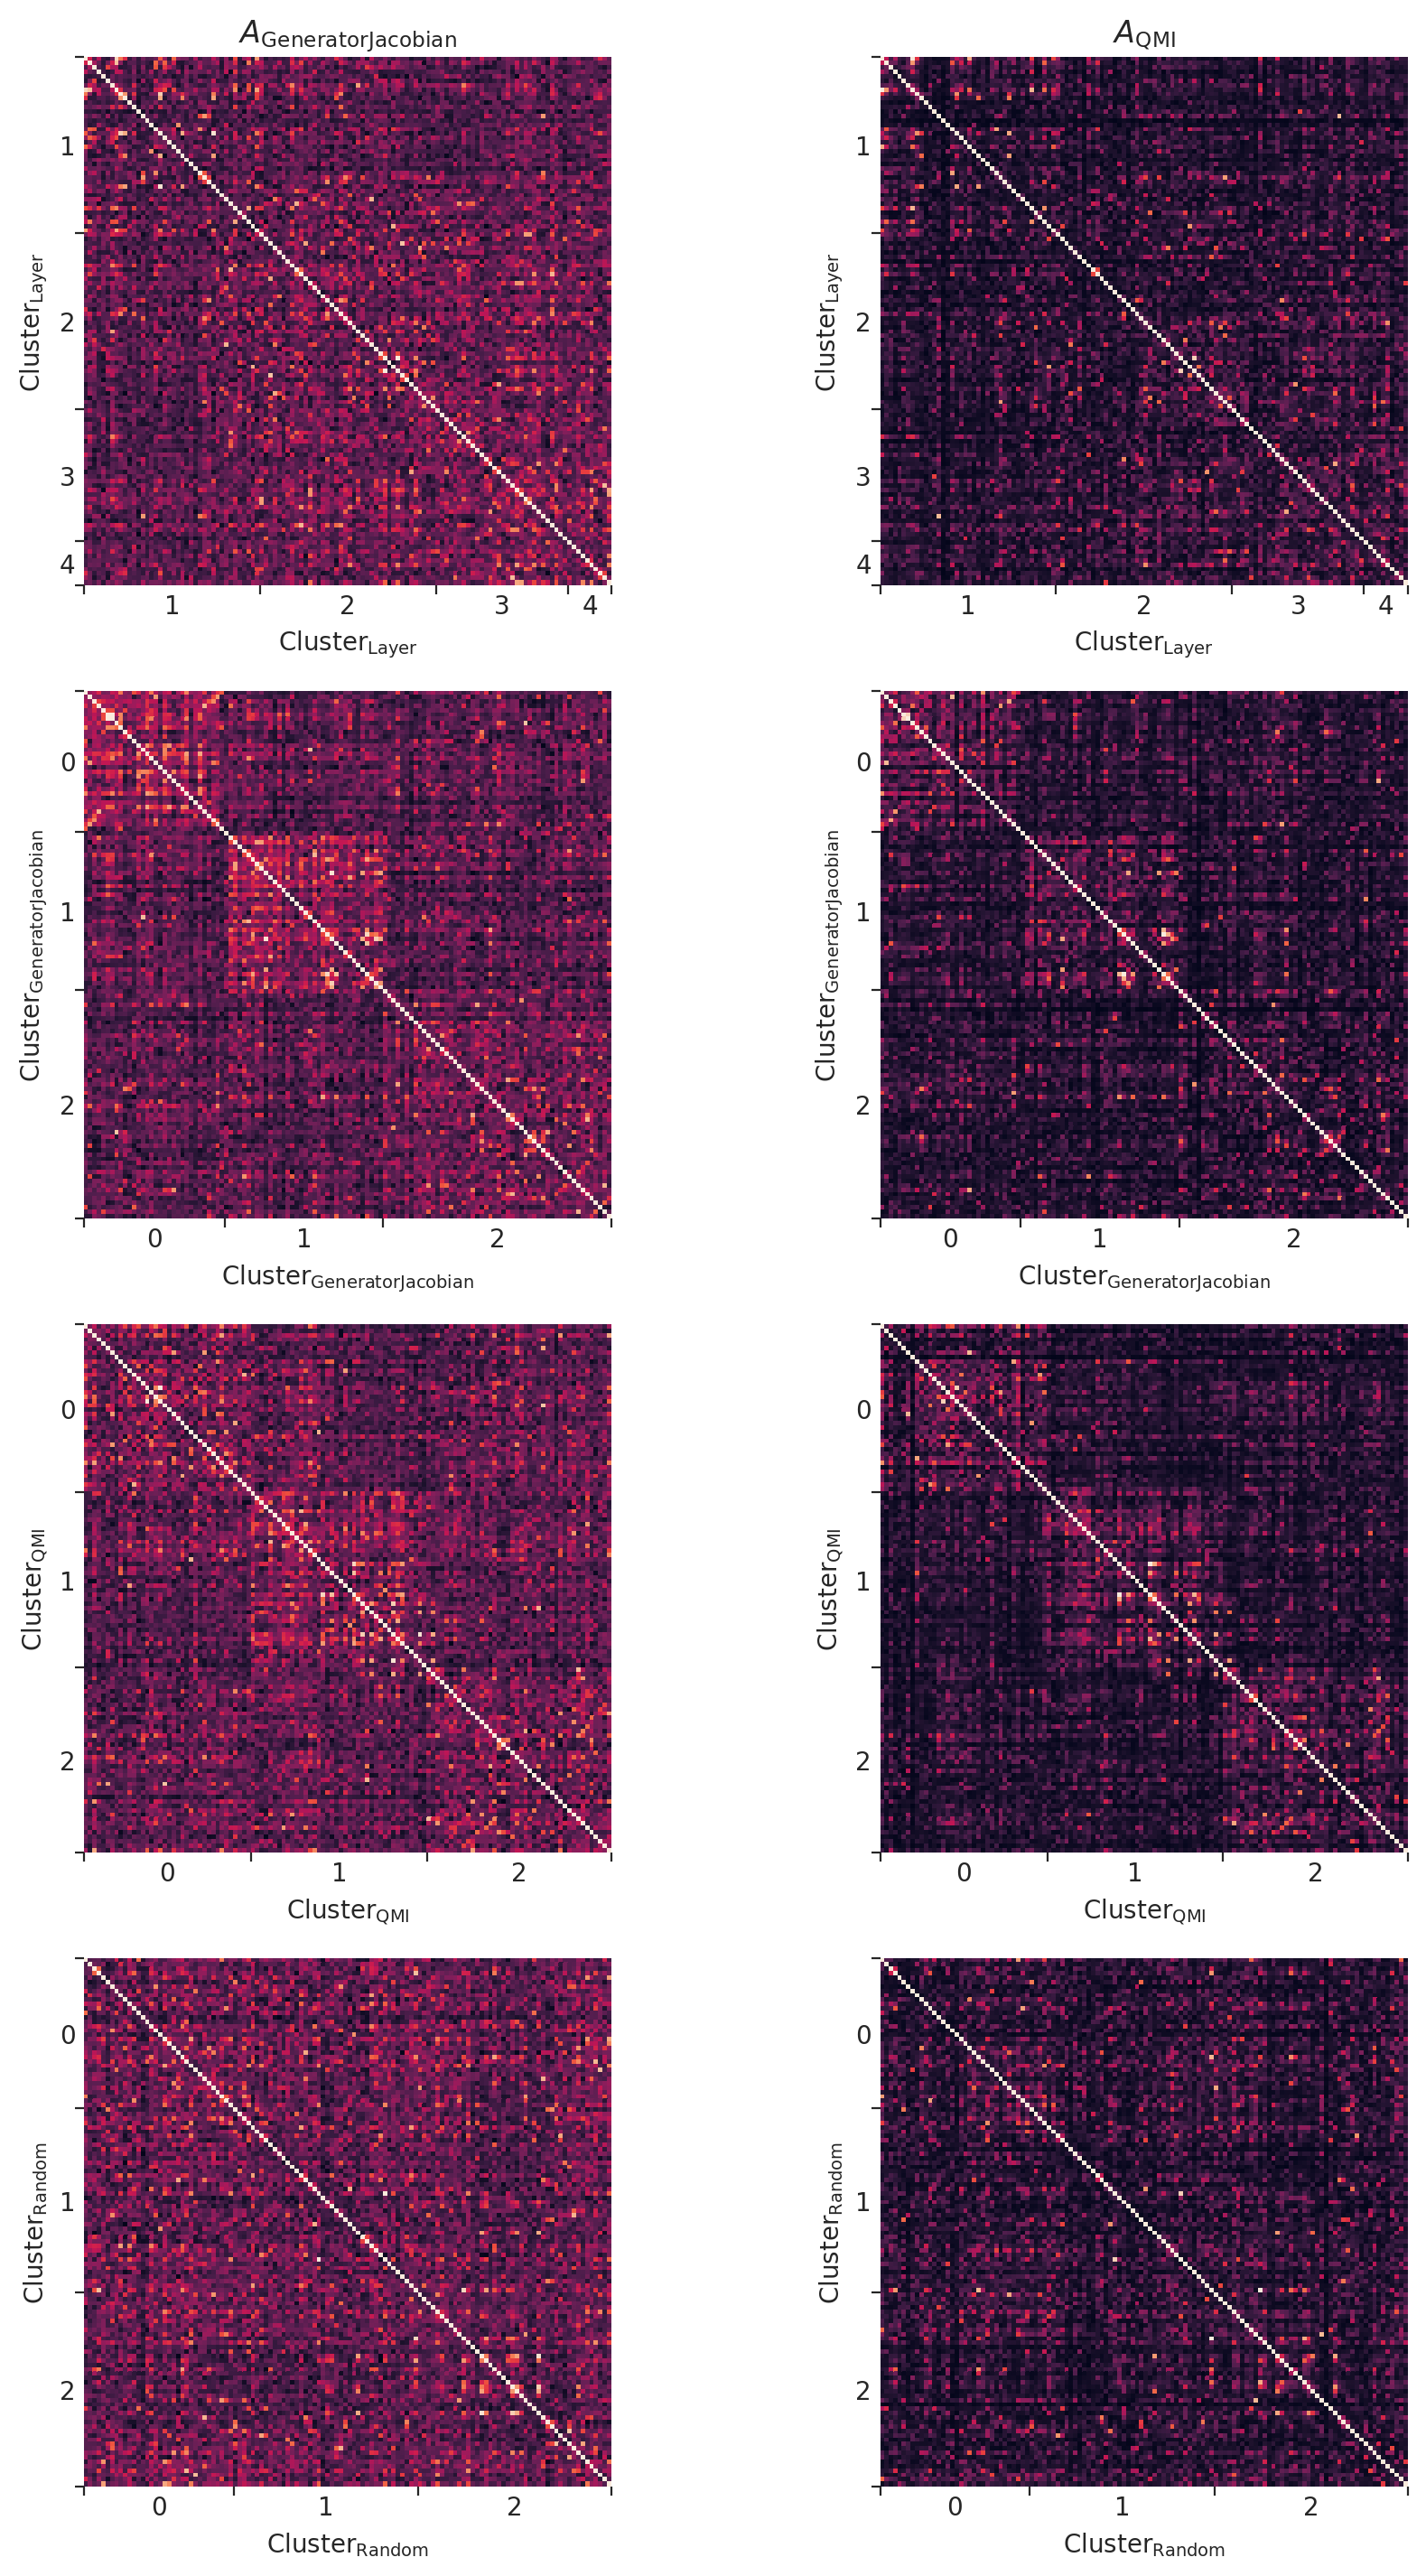

In [26]:
n_rows = len(clusters)
n_cols = len(adjacency_matrices)
fig, axs = plt.subplots(
    n_rows,
    n_cols,
    figsize=(4.8 * n_cols, 3.6 * n_rows),
    dpi=100,
)
axs = axs.reshape(n_rows, n_cols)
pbar = tqdm(total=n_rows * n_cols)
for i_row, (cluster_name, i_cluster) in enumerate(clusters.items()):
    for i_col, (adj_mat_name, adj_mat) in enumerate(adjacency_matrices.items()):
        pbar.update(1)
        ax = axs[i_row, i_col]

        # Sort adjacency matrix
        i_sort = np.argsort(i_cluster)
        adj_mat = adj_mat[i_sort, :][:, i_sort]

        # Heatmap
        vmax = adj_mat[~np.eye(i_sort.size, dtype=bool)].max()
        sns.heatmap(adj_mat, ax=ax, square=True, cbar=False, vmax=vmax)
        
        # Set column title
        if i_row==0:
            ax.set_title(r"$A_\mathrm{" + adj_mat_name + "}$")

        # Set cluster name
        xy_label = r"Cluster$_\mathrm{" + cluster_name + "}$"
        ax.set_ylabel(xy_label)
        ax.set_xlabel(xy_label)

        # Set ticks
        labels, counts = np.unique(i_cluster, return_counts=True)
        ticks = np.cumsum([0, *counts])
        centered_ticks = (ticks[1:] + ticks[:-1]) / 2
        ticklabels = labels
        for subax in [ax.xaxis, ax.yaxis]:
            subax.set_major_locator(ticker.FixedLocator(ticks))
            subax.set_major_formatter(ticker.NullFormatter())
            subax.set_minor_locator(ticker.FixedLocator(centered_ticks))
            subax.set_minor_formatter(ticker.FixedFormatter(ticklabels))
        ax.tick_params(which="minor", length=0.0)

pbar.close()

fig.tight_layout()

## Looking at modules

In [27]:
i_module = clusters["Jacobian"] + 0.1 * np.random.randn(120)
i_layer = clusters["Layer"] + 0.1 * np.random.randn(120)

plt.plot(i_module, i_layer, '.', ms=5, alpha=0.5)
plt.xlabel("Module")
plt.ylabel("Layer");

KeyError: ignored

In [29]:
import torch
n = 25
m = 3
a = torch.rand(n, n)
i_block = torch.randint(m, (n,))
i_sort = i_block.argsort()
b = torch.zeros(*a.shape)
for i in range(m):
    mask = (i_block == i) & (i_block == i).unsqueeze(1)
    b[mask] = a[mask]
torch.allclose((torch.inverse(b) @ a).diag(), torch.ones(1))


True

In [30]:
a = torch.rand(n, n)
a = (a + a.T) / 2
b = torch.zeros(n, n)
mask = torch.eye(n, dtype=bool)
b[mask] = a[mask]
print(torch.trace(a @ a), torch.trace(b @ b))

tensor(201.0391) tensor(10.0938)


(-200.0, 200.0)

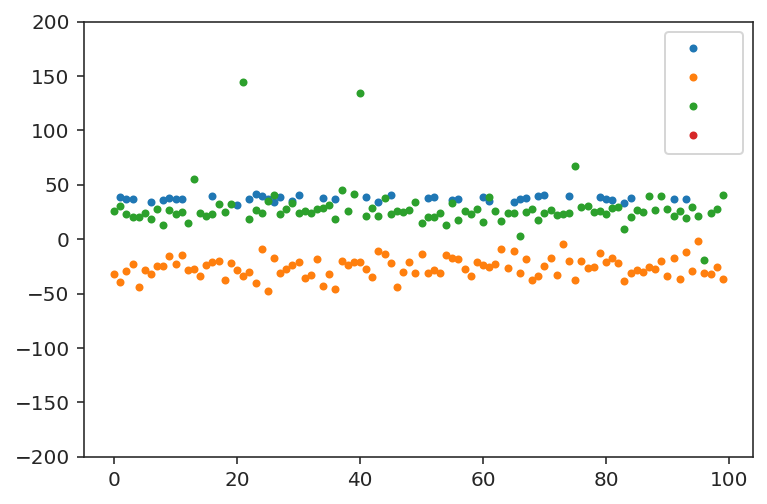

In [31]:
import matplotlib.pyplot as plt
n = 25
rep = 100
def foo(i):
    a = torch.randn(n, n)
    a = a + a.T
    yield torch.log(torch.det(a))
    yield torch.trace(a - torch.eye(n))
    yield torch.trace(torch.eye(n) - torch.inverse(a))
    yield 0.5 * torch.trace(a @ a - torch.eye(n))

plt.plot(range(rep), [list(foo(i)) for i in range(rep)], ".", label=" ")
plt.legend()
plt.ylim([-200, 200])


